In [6]:
import scipy.io as sio
import numpy as np
import os

# Set up data directory
data_dir = './data_ephys/'

# List available subjects
subjects = []
for file in os.listdir(data_dir):
    if file.endswith('.mat') and file.startswith('s'):
        subject_id = file.split('_')[0]  # Extract s01, s02, etc.
        subjects.append(subject_id)

print(f"Available subjects: {sorted(set(subjects))}")

Available subjects: ['s01', 's02', 's04', 's06', 's07', 's08', 's10']


In [10]:
# Start with subject s01 for initial analysis
target_subject = 's01'
print(f"Selected subject: {target_subject}")

Selected subject: s01


In [14]:
# Load electrophysiology data
ephys_file = f'{data_dir}{target_subject}_ofc_hg_events.mat'
data = sio.loadmat(ephys_file)

# Examine data structure
print("Available data variables:")
for key in data.keys():
    if not key.startswith('__'):
        print(f"  {key}: {data[key].shape if hasattr(data[key], 'shape') else type(data[key])}")

Available data variables:
  buttonpress_events_hg: (180, 3001, 5)
  buttonpress_window_events_hg: (180, 57, 5)
  game_events_hg: (180, 3001, 5)
  game_window_events_hg: (180, 57, 5)


In [16]:
# Load the main data matrices
game_data = data['game_events_hg']  # nTrials × nTimePoints × nElectrodes
button_data = data['buttonpress_events_hg']  # nTrials × nTimePoints × nElectrodes

print(f"Game-locked data shape: {game_data.shape}")
print(f"Button-locked data shape: {button_data.shape}")
print(f"Number of electrodes: {game_data.shape[2]}")
print(f"Number of trials: {game_data.shape[0]}")
print(f"Time points per trial: {game_data.shape[1]}")

Game-locked data shape: (180, 3001, 5)
Button-locked data shape: (180, 3001, 5)
Number of electrodes: 5
Number of trials: 180
Time points per trial: 3001


In [18]:
# Check for NaN values or artifacts
def check_data_quality(data_matrix, data_name):
    print(f"\n{data_name} Quality Assessment:")
    print(f"  Contains NaN: {np.isnan(data_matrix).any()}")
    print(f"  Contains Inf: {np.isinf(data_matrix).any()}")
    
    # Check electrode-wise signal quality
    electrode_quality = []
    for e in range(data_matrix.shape[2]):
        electrode_data = data_matrix[:, :, e]
        
        # Calculate basic statistics
        mean_activity = np.mean(electrode_data)
        std_activity = np.std(electrode_data)
        snr = abs(mean_activity) / std_activity if std_activity > 0 else 0
        
        electrode_quality.append({
            'electrode': e,
            'mean': mean_activity,
            'std': std_activity,
            'snr': snr,
            'has_nan': np.isnan(electrode_data).any(),
            'has_inf': np.isinf(electrode_data).any()
        })
    
    return electrode_quality

# Assess both datasets
game_quality = check_data_quality(game_data, "Game-locked data")
button_quality = check_data_quality(button_data, "Button-locked data")


Game-locked data Quality Assessment:
  Contains NaN: False
  Contains Inf: False

Button-locked data Quality Assessment:
  Contains NaN: False
  Contains Inf: False


In [22]:
import pandas as pd
csv_file = f'{behav_dir}gamble.data.{target_subject}.csv'
trial_data = pd.read_csv(csv_file)

print("Behavioral data columns:")
print(trial_data.columns.tolist())
print(f"\nNumber of behavioral trials: {len(trial_data)}")

Behavioral data columns:
['round', 'newround.time', 'choice.time', 'buttonpress.time', 'conf.time', 'reveal.time', 'choice.location', 'choice.class', 'outcome']

Number of behavioral trials: 200


In [24]:
def find_task_responsive_electrodes(data_matrix, percentile_threshold=75):
    """
    Find electrodes that show strong task-related activity
    """
    n_electrodes = data_matrix.shape[2]
    electrode_responsiveness = []
    
    for e in range(n_electrodes):
        electrode_data = data_matrix[:, :, e]  # trials × time
        
        # Calculate trial-averaged response
        avg_response = np.mean(electrode_data, axis=0)
        
        # Calculate response variance (higher = more task-related)
        response_variance = np.var(avg_response)
        
        # Calculate peak-to-peak amplitude
        peak_to_peak = np.max(avg_response) - np.min(avg_response)
        
        electrode_responsiveness.append({
            'electrode': e,
            'variance': response_variance,
            'peak_to_peak': peak_to_peak,
            'mean_activity': np.mean(electrode_data)
        })
    
    # Sort by responsiveness
    electrode_responsiveness.sort(key=lambda x: x['variance'], reverse=True)
    
    # Get top responsive electrodes
    threshold = np.percentile([e['variance'] for e in electrode_responsiveness], 
                            percentile_threshold)
    
    responsive_electrodes = [e for e in electrode_responsiveness 
                           if e['variance'] >= threshold]
    
    return responsive_electrodes, electrode_responsiveness

# Find responsive electrodes for both time-locked conditions
game_responsive, game_all = find_task_responsive_electrodes(game_data)
button_responsive, button_all = find_task_responsive_electrodes(button_data)

print(f"Top 10 most responsive electrodes (game-locked):")
for i, elec in enumerate(game_responsive[:10]):
    print(f"  Electrode {elec['electrode']}: variance={elec['variance']:.4f}")

Top 10 most responsive electrodes (game-locked):
  Electrode 3: variance=0.5775
  Electrode 1: variance=0.3675


In [26]:
def analyze_electrode_distribution(responsive_electrodes, n_select=5):
    """
    Select electrodes ensuring spatial distribution
    """
    # For this dataset, we don't have explicit spatial coordinates
    # But we can assume electrodes are somewhat spatially organized by index
    
    selected_electrodes = []
    electrode_indices = [e['electrode'] for e in responsive_electrodes]
    
    if len(electrode_indices) >= n_select:
        # Simple strategy: select every nth electrode to ensure distribution
        step = len(electrode_indices) // n_select
        for i in range(0, len(electrode_indices), step):
            if len(selected_electrodes) < n_select:
                selected_electrodes.append(electrode_indices[i])
    else:
        selected_electrodes = electrode_indices
    
    return selected_electrodes[:n_select]

# Select 3-5 electrodes for DCM analysis
selected_electrodes = analyze_electrode_distribution(game_responsive, n_select=4)
print(f"\nSelected electrodes for DCM: {selected_electrodes}")


Selected electrodes for DCM: [3, 1]


In [28]:
def extract_electrode_timeseries(data_matrix, electrode_indices):
    """
    Extract time series for selected electrodes
    """
    # Extract data for selected electrodes
    selected_data = data_matrix[:, :, electrode_indices]  # trials × time × electrodes
    
    # Reshape to (time_points, electrodes) for DCM
    n_trials, n_time, n_electrodes = selected_data.shape
    
    # Option 1: Concatenate all trials
    concatenated_data = selected_data.reshape(-1, n_electrodes)  # (trials*time) × electrodes
    
    # Option 2: Average across trials (for initial analysis)
    averaged_data = np.mean(selected_data, axis=0)  # time × electrodes
    
    return {
        'concatenated': concatenated_data,
        'averaged': averaged_data,
        'original_shape': selected_data.shape,
        'electrode_indices': electrode_indices
    }

# Extract time series
game_timeseries = extract_electrode_timeseries(game_data, selected_electrodes)
button_timeseries = extract_electrode_timeseries(button_data, selected_electrodes)

print(f"Extracted time series shapes:")
print(f"  Game-locked (concatenated): {game_timeseries['concatenated'].shape}")
print(f"  Game-locked (averaged): {game_timeseries['averaged'].shape}")

Extracted time series shapes:
  Game-locked (concatenated): (540180, 2)
  Game-locked (averaged): (3001, 2)


In [30]:
def preprocess_timeseries(timeseries_data, sampling_rate=1000):
    """
    Basic preprocessing for DCM
    """
    # Remove DC component
    timeseries_centered = timeseries_data - np.mean(timeseries_data, axis=0)
    
    # Z-score normalization per electrode
    timeseries_normalized = (timeseries_centered - np.mean(timeseries_centered, axis=0)) / np.std(timeseries_centered, axis=0)
    
    return timeseries_normalized

# Preprocess the selected time series
game_processed = preprocess_timeseries(game_timeseries['concatenated'])
button_processed = preprocess_timeseries(button_timeseries['concatenated'])

print(f"Processed data shapes:")
print(f"  Game-locked: {game_processed.shape}")
print(f"  Button-locked: {button_processed.shape}")

Processed data shapes:
  Game-locked: (540180, 2)
  Button-locked: (540180, 2)


In [32]:
# Create final data structure for DCM
dcm_data = {
    'subject_id': target_subject,
    'selected_electrodes': selected_electrodes,
    'game_locked': {
        'Y': game_processed,  # Time series data (time × electrodes)
        'dt': 1/1000,        # Sampling interval (1ms)
        'electrode_info': [game_responsive[i] for i in range(len(selected_electrodes))]
    },
    'button_locked': {
        'Y': button_processed,
        'dt': 1/1000,
        'electrode_info': [button_responsive[i] for i in range(len(selected_electrodes))]
    },
    'behavioral_data': trial_data
}

# Save processed data
import pickle
with open(f'dcm_ready_data_{target_subject}.pkl', 'wb') as f:
    pickle.dump(dcm_data, f)

print("Data preparation complete!")
print(f"Selected {len(selected_electrodes)} electrodes: {selected_electrodes}")
print(f"Data ready for DCM analysis")

Data preparation complete!
Selected 2 electrodes: [3, 1]
Data ready for DCM analysis


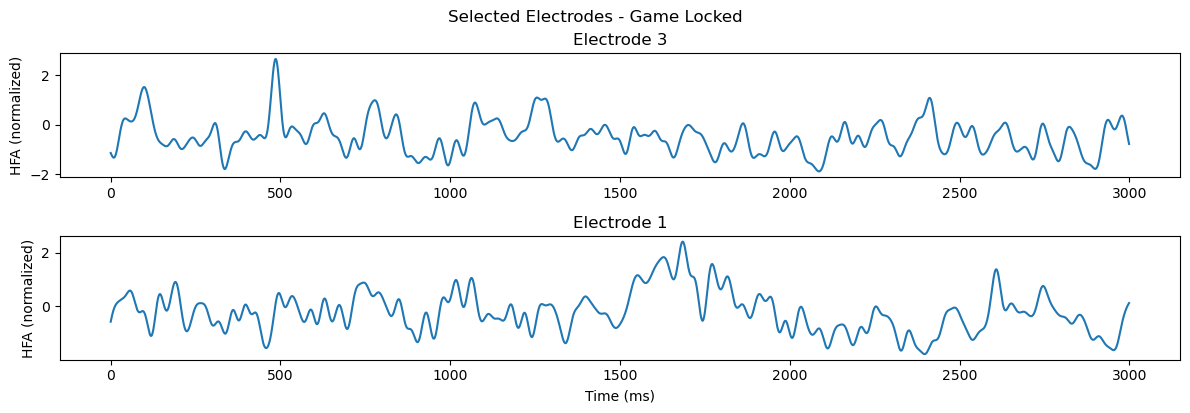

In [34]:
import matplotlib.pyplot as plt

def visualize_selected_electrodes(timeseries_data, electrode_indices, title="Selected Electrodes"):
    """
    Visualize time series from selected electrodes
    """
    fig, axes = plt.subplots(len(electrode_indices), 1, figsize=(12, 2*len(electrode_indices)))
    if len(electrode_indices) == 1:
        axes = [axes]
    
    for i, elec_idx in enumerate(electrode_indices):
        # Show first 3000 time points (3 seconds at 1kHz)
        axes[i].plot(timeseries_data[:3000, i])
        axes[i].set_title(f'Electrode {elec_idx}')
        axes[i].set_ylabel('HFA (normalized)')
        if i == len(electrode_indices) - 1:
            axes[i].set_xlabel('Time (ms)')
    
    plt.tight_layout()
    plt.suptitle(title, y=1.02)
    plt.show()

# Visualize selected electrodes
visualize_selected_electrodes(game_processed, selected_electrodes, 
                            "Selected Electrodes - Game Locked")

In [36]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# Load you processed data
with open('dcm_ready_data_s01.pkl', 'rb') as f:
    dcm_data = pickle.load(f)

behavioral_data = dcm_data['behavioral_data']

# Examine the gambling task structure
print("Task Structure Analysis:")
print(f"Total behavioral trials: {len(behavioral_data)}")
print(f"Neural trials available: {dcm_data['game_locked']['Y'].shape[0] // 3001}")

print("\nChoice types:")
print(behavioral_data['choice.class'].value_counts())

print("\nOutcomes:")
print(behavioral_data['outcome'].value_counts())

print("\nTiming columns:")
timing_cols = ['newround.time', 'buttonpress.time', 'reveal.time']
print(behavioral_data[timing_cols].head())

Task Structure Analysis:
Total behavioral trials: 200
Neural trials available: 180

Choice types:
choice.class
Gamble     124
Safebet     72
Timeout      4
Name: count, dtype: int64

Outcomes:
outcome
Win              87
WouldHaveLost    49
Loss             37
WouldHaveWon     23
Timeout           4
Name: count, dtype: int64

Timing columns:
   newround.time  buttonpress.time  reveal.time
0          6.191             8.003        8.535
1          9.550            11.441       11.972
2         12.988            14.832       15.363
3         16.378            18.144       18.691
4         19.707            21.519       22.066


In [38]:
def create_dcm_inputs_gambling_task():
    """
    Define the three DCM inputs for gambling task:
    1. Driving input: Game presentation (sensory)
    2. Modulatory input 1: Choice type (gamble vs safe)  
    3. Modulatory input 2: Outcome valence (win vs loss)
    """
    
    input_definitions = {
        'Input_1_GameOnset': {
            'type': 'driving',
            'description': 'Game presentation onset - sensory input',
            'drives_electrodes': [0, 1],  # Can drive both electrodes
            'behavioral_event': 'newround.time'
        },
        
        'Input_2_ChoiceType': {
            'type': 'modulatory', 
            'description': 'Choice type context (gamble=1, safebet=0)',
            'modulates_connections': 'between_electrodes',
            'behavioral_variable': 'choice.class'
        },
        
        'Input_3_Outcome': {
            'type': 'modulatory',
            'description': 'Outcome valence (win=1, loss=0)', 
            'modulates_connections': 'self_connections',
            'behavioral_variable': 'outcome'
        }
    }
    
    return input_definitions

input_defs = create_dcm_inputs_gambling_task()
for key, val in input_defs.items():
    print(f"{key}: {val['description']}")

Input_1_GameOnset: Game presentation onset - sensory input
Input_2_ChoiceType: Choice type context (gamble=1, safebet=0)
Input_3_Outcome: Outcome valence (win=1, loss=0)


In [40]:
def create_input_timeseries(behavioral_data, neural_length, sampling_rate=1000):
    """
    Create DCM input matrix aligned with neural data
    """
    # Initialize input matrix: time × inputs
    U = np.zeros((neural_length, 3))
    
    # Parameters
    dt = 1/sampling_rate  # 1ms time steps
    trial_length = 3001   # 3001 time points per trial
    
    # Get valid trials (exclude timeouts)
    valid_trials = behavioral_data[behavioral_data['choice.class'] != 'Timeout'].copy()
    valid_trials = valid_trials.reset_index(drop=True)
    
    print(f"Valid trials for DCM: {len(valid_trials)}")
    
    # Create inputs for each trial
    for trial_idx, trial in valid_trials.iterrows():
        if trial_idx >= neural_length // trial_length:
            break  # Don't exceed neural data length
            
        # Calculate trial start in neural data
        trial_start = trial_idx * trial_length
        trial_end = trial_start + trial_length
        
        if trial_end > neural_length:
            break
            
        # INPUT 1: Game onset (driving input)
        # Create impulse at trial start (game presentation)
        game_onset_sample = trial_start + 750  # Game presents at 750ms
        if game_onset_sample < neural_length:
            U[game_onset_sample, 0] = 1.0
        
        # INPUT 2: Choice type (modulatory - sustained)
        # 1 for Gamble, 0 for Safebet
        choice_value = 1.0 if trial['choice.class'] == 'Gamble' else 0.0
        
        # Sustained from game onset to choice
        choice_start = trial_start + 750
        choice_duration = 2000  # Up to 2s choice period
        choice_end = min(choice_start + choice_duration, trial_end)
        
        U[choice_start:choice_end, 1] = choice_value
        
        # INPUT 3: Outcome (modulatory - transient)
        # 1 for Win outcomes, 0 for Loss outcomes  
        outcome_value = 1.0 if 'Won' in str(trial['outcome']) else 0.0
        
        # Outcome revealed at ~1.3s after choice (550ms delay)
        outcome_sample = choice_start + 550
        outcome_duration = 500  # 500ms outcome processing
        outcome_end = min(outcome_sample + outcome_duration, trial_end)
        
        if outcome_sample < neural_length:
            U[outcome_sample:outcome_end, 2] = outcome_value
    
    return U

# Create the input matrix
U = create_input_timeseries(behavioral_data, dcm_data['game_locked']['Y'].shape[0])

print(f"Input matrix shape: {U.shape}")
print(f"Input 1 (Game onset) events: {np.sum(U[:, 0])}")
print(f"Input 2 (Choice type) active timepoints: {np.sum(U[:, 1] > 0)}")
print(f"Input 3 (Outcome) active timepoints: {np.sum(U[:, 2] > 0)}")

Valid trials for DCM: 196
Input matrix shape: (540180, 3)
Input 1 (Game onset) events: 180.0
Input 2 (Choice type) active timepoints: 224000
Input 3 (Outcome) active timepoints: 11500


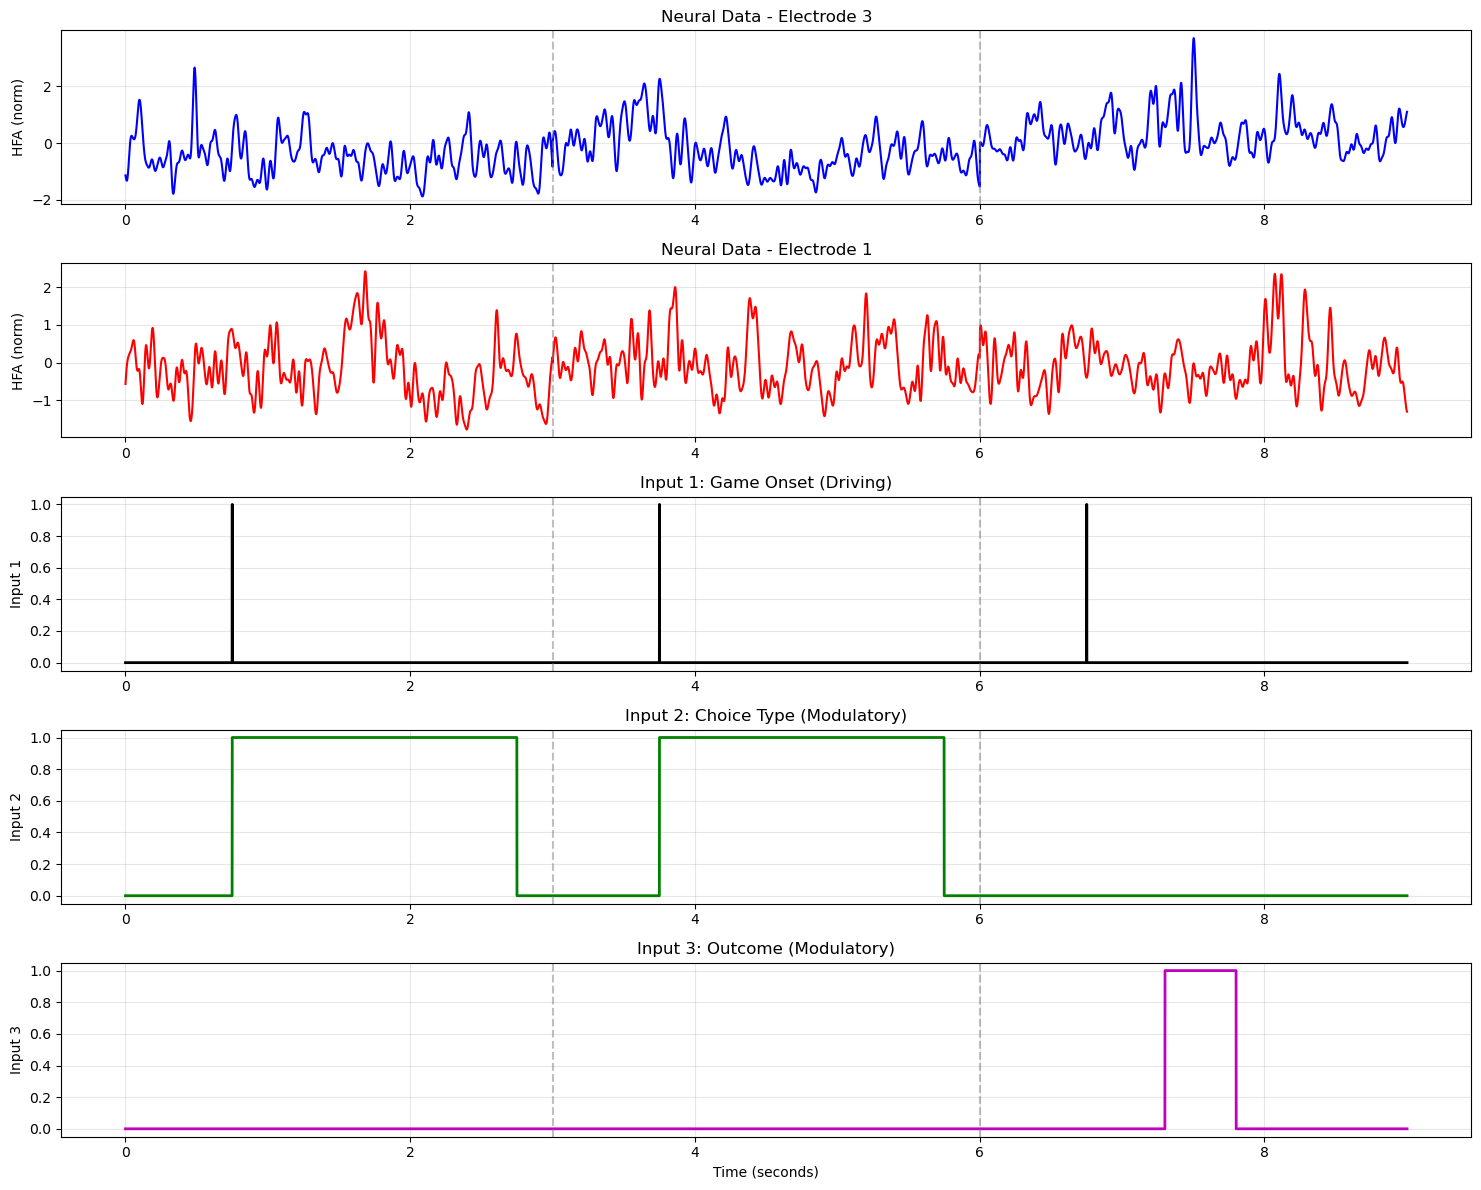

In [42]:
def visualize_dcm_inputs(U, Y, trial_length=3001, n_trials_show=3):
    """
    Visualize DCM inputs alongside neural data
    """
    fig, axes = plt.subplots(5, 1, figsize=(15, 12))
    
    # Show first few trials
    end_sample = n_trials_show * trial_length
    time_axis = np.arange(end_sample) / 1000  # Convert to seconds
    
    # Plot neural data
    axes[0].plot(time_axis, Y[:end_sample, 0], 'b-', label='Electrode 3')
    axes[0].set_ylabel('HFA (norm)')
    axes[0].set_title('Neural Data - Electrode 3')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(time_axis, Y[:end_sample, 1], 'r-', label='Electrode 1') 
    axes[1].set_ylabel('HFA (norm)')
    axes[1].set_title('Neural Data - Electrode 1')
    axes[1].grid(True, alpha=0.3)
    
    # Plot inputs
    axes[2].plot(time_axis, U[:end_sample, 0], 'k-', linewidth=2)
    axes[2].set_ylabel('Input 1')
    axes[2].set_title('Input 1: Game Onset (Driving)')
    axes[2].grid(True, alpha=0.3)
    
    axes[3].plot(time_axis, U[:end_sample, 1], 'g-', linewidth=2)
    axes[3].set_ylabel('Input 2') 
    axes[3].set_title('Input 2: Choice Type (Modulatory)')
    axes[3].grid(True, alpha=0.3)
    
    axes[4].plot(time_axis, U[:end_sample, 2], 'm-', linewidth=2)
    axes[4].set_ylabel('Input 3')
    axes[4].set_title('Input 3: Outcome (Modulatory)')
    axes[4].set_xlabel('Time (seconds)')
    axes[4].grid(True, alpha=0.3)
    
    # Add trial boundaries
    for i in range(1, n_trials_show):
        trial_boundary = i * trial_length / 1000
        for ax in axes:
            ax.axvline(trial_boundary, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Visualize the design
visualize_dcm_inputs(U, dcm_data['game_locked']['Y'])

In [44]:
# Create final DCM input structure
dcm_inputs = {
    'U': U,  # Input matrix (time × inputs)
    'dt': 1/1000,  # Sampling interval
    'input_names': ['GameOnset', 'ChoiceType', 'Outcome'],
    'input_descriptions': {
        'GameOnset': 'Driving input - game presentation onset',
        'ChoiceType': 'Modulatory input - choice context (gamble vs safe)',
        'Outcome': 'Modulatory input - outcome valence (win vs loss)'
    },
    'input_types': ['driving', 'modulatory', 'modulatory']
}

# Add to you DCM data structure
dcm_data['inputs'] = dcm_inputs

# Save updated data
with open('dcm_ready_data_s01.pkl', 'wb') as f:
    pickle.dump(dcm_data, f)

print("Phase 2 Complete!")
print("DCM inputs created and saved.")
print(f"Input matrix shape: {U.shape}")
print("Ready for Phase 3: Network Architecture Design")

Phase 2 Complete!
DCM inputs created and saved.
Input matrix shape: (540180, 3)
Ready for Phase 3: Network Architecture Design


In [46]:
#phase 3 
import numpy as np
import matplotlib.pyplot as plt

def design_2electrode_architecture():
    """
    Design DCM architecture for 2-electrode OFC network
    Based on: Electrode 3 (most responsive) and Electrode 1
    """
    
    architecture = {
        'regions': ['Electrode_3', 'Electrode_1'],
        'n_regions': 2,
        'connections': {
            'intrinsic': {
                'E3_to_E1': 'Forward connection - risk processing to decision',
                'E1_to_E3': 'Backward connection - decision feedback to risk processing', 
                'E3_self': 'Self-connection - local dynamics',
                'E1_self': 'Self-connection - local dynamics'
            },
            'driving': {
                'Input1_to_E3': 'Game onset drives most responsive electrode',
                'Input1_to_E1': 'Game onset can also drive second electrode (optional)'
            },
            'modulatory': {
                'Input2_modulates_E3_E1': 'Choice type modulates forward connection',
                'Input3_modulates_self': 'Outcome modulates self-connections'
            }
        }
    }
    
    return architecture

arch = design_2electrode_architecture()
print("DCM Network Architecture:")
for region in arch['regions']:
    print(f"  {region}")

DCM Network Architecture:
  Electrode_3
  Electrode_1


In [48]:
def create_dcm_matrices():
    """
    Create A, B, and C matrices for 2-electrode DCM
    """
    n_regions = 2
    n_inputs = 3
    
    # A matrix - Intrinsic connections (2x2)
    # A[i,j] = connection FROM region j TO region i
    A_prior = np.array([
        [-1.0,  0.5],  # Row 0: connections TO Electrode 3
        [ 0.8, -1.0]   # Row 1: connections TO Electrode 1  
    ])
    # Diagonal: self-connections (negative = decay)
    # Off-diagonal: inter-regional connections
    
    # C matrix - Driving inputs (2x3)  
    # C[i,j] = INPUT j drives REGION i
    C_prior = np.array([
        [1.0, 0.0, 0.0],  # Input 1 drives Electrode 3
        [0.5, 0.0, 0.0]   # Input 1 can also drive Electrode 1 (weaker)
    ])
    
    # B matrices - Bilinear modulations (2x2x3)
    # B[j][i,k] = INPUT j modulates connection from region k to region i
    B_prior = np.zeros((n_inputs, n_regions, n_regions))
    
    # B1: Input 1 (Game onset) - no modulation for driving input
    B_prior[0, :, :] = 0.0
    
    # B2: Input 2 (Choice type) modulates forward connection
    B_prior[1, 1, 0] = 0.3  # Modulates E3→E1 connection
    
    # B3: Input 3 (Outcome) modulates self-connections  
    B_prior[2, 0, 0] = 0.2  # Modulates E3 self-connection
    B_prior[2, 1, 1] = 0.2  # Modulates E1 self-connection
    
    return A_prior, B_prior, C_prior

A, B, C = create_dcm_matrices()

print("DCM Matrices Created:")
print(f"A (intrinsic): {A.shape}")
print(f"B (modulatory): {B.shape}") 
print(f"C (driving): {C.shape}")

print(f"\nA matrix (intrinsic connections):")
print(A)
print(f"\nC matrix (driving inputs):")
print(C)

DCM Matrices Created:
A (intrinsic): (2, 2)
B (modulatory): (3, 2, 2)
C (driving): (2, 3)

A matrix (intrinsic connections):
[[-1.   0.5]
 [ 0.8 -1. ]]

C matrix (driving inputs):
[[1.  0.  0. ]
 [0.5 0.  0. ]]


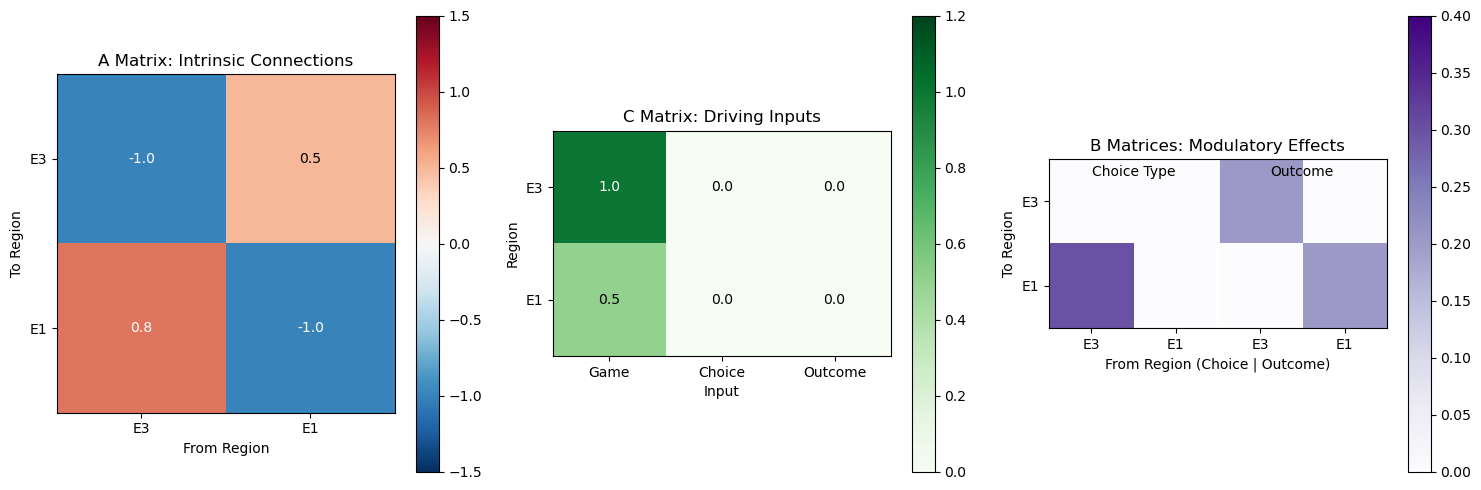

In [50]:
def visualize_dcm_architecture(A, B, C):
    """
    Visualize the DCM network architecture
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Plot A matrix (intrinsic connections)
    im1 = axes[0].imshow(A, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    axes[0].set_title('A Matrix: Intrinsic Connections')
    axes[0].set_xticks([0, 1])
    axes[0].set_yticks([0, 1])
    axes[0].set_xticklabels(['E3', 'E1'])
    axes[0].set_yticklabels(['E3', 'E1'])
    axes[0].set_xlabel('From Region')
    axes[0].set_ylabel('To Region')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            axes[0].text(j, i, f'{A[i,j]:.1f}', ha='center', va='center', 
                        color='white' if abs(A[i,j]) > 0.5 else 'black')
    
    plt.colorbar(im1, ax=axes[0])
    
    # Plot C matrix (driving inputs)
    im2 = axes[1].imshow(C, cmap='Greens', vmin=0, vmax=1.2)
    axes[1].set_title('C Matrix: Driving Inputs')
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_yticks([0, 1])
    axes[1].set_xticklabels(['Game', 'Choice', 'Outcome'])
    axes[1].set_yticklabels(['E3', 'E1'])
    axes[1].set_xlabel('Input')
    axes[1].set_ylabel('Region')
    
    for i in range(2):
        for j in range(3):
            axes[1].text(j, i, f'{C[i,j]:.1f}', ha='center', va='center',
                        color='white' if C[i,j] > 0.5 else 'black')
    
    plt.colorbar(im2, ax=axes[1])
    
    # Plot B matrices (modulatory effects)
    B_combined = np.concatenate([B[1], B[2]], axis=1)  # Show B2 and B3
    im3 = axes[2].imshow(B_combined, cmap='Purples', vmin=0, vmax=0.4)
    axes[2].set_title('B Matrices: Modulatory Effects')
    axes[2].set_xticks([0, 1, 2, 3])
    axes[2].set_yticks([0, 1])
    axes[2].set_xticklabels(['E3', 'E1', 'E3', 'E1'])
    axes[2].set_yticklabels(['E3', 'E1'])
    axes[2].set_xlabel('From Region (Choice | Outcome)')
    axes[2].set_ylabel('To Region')
    
    # Add separating line
    axes[2].axvline(1.5, color='white', linewidth=2)
    axes[2].text(0.5, -0.3, 'Choice Type', ha='center', transform=axes[2].transData)
    axes[2].text(2.5, -0.3, 'Outcome', ha='center', transform=axes[2].transData)
    
    plt.colorbar(im3, ax=axes[2])
    plt.tight_layout()
    plt.show()

visualize_dcm_architecture(A, B, C)

In [52]:
# Create complete DCM architecture specification
dcm_architecture = {
    'network': {
        'regions': ['Electrode_3', 'Electrode_1'],
        'n_regions': 2,
        'electrode_indices': [3, 1]  # Original electrode numbers
    },
    
    'connectivity': {
        'A': A,  # Intrinsic connections
        'B': B,  # Modulatory connections  
        'C': C   # Driving connections
    },
    
    'priors': {
        'A_variance': 0.5,  # Prior variance for intrinsic connections
        'B_variance': 0.2,  # Prior variance for modulatory connections
        'C_variance': 1.0,  # Prior variance for driving connections
        'self_connection_prior': -1.0,  # Expected self-connection strength
        'connection_threshold': 0.1  # Minimum meaningful connection
    },
    
    'hypotheses': {
        'H1': 'Electrode 3 → Electrode 1 (forward processing)',
        'H2': 'Choice type modulates E3→E1 connection', 
        'H3': 'Outcome modulates self-connections',
        'H4': 'Game onset drives both electrodes'
    }
}

# Add architecture to DCM data
with open('dcm_ready_data_s01.pkl', 'rb') as f:
    dcm_data = pickle.load(f)

dcm_data['architecture'] = dcm_architecture

# Save complete DCM specification
with open('dcm_ready_data_s01.pkl', 'wb') as f:
    pickle.dump(dcm_data, f)

print("Phase 3 Complete!")
print("DCM Architecture designed and saved:")
print(f"  - {dcm_architecture['network']['n_regions']} regions")
print(f"  - {len(dcm_architecture['hypotheses'])} testable hypotheses")
print("Ready for Phase 4: Model Specification!")

Phase 3 Complete!
DCM Architecture designed and saved:
  - 2 regions
  - 4 testable hypotheses
Ready for Phase 4: Model Specification!


In [54]:
import numpy as np
import pickle
from scipy import linalg
import matplotlib.pyplot as plt

# Load you DCM data
with open('dcm_ready_data_s01.pkl', 'rb') as f:
    dcm_data = pickle.load(f)

def setup_dcm_specification():
    """
    Complete DCM specification for parameter estimation
    """
    # Extract components
    Y = dcm_data['game_locked']['Y']  # Neural data (time × regions)
    U = dcm_data['inputs']['U']       # Input data (time × inputs) 
    A = dcm_data['architecture']['connectivity']['A']  # Intrinsic connections
    B = dcm_data['architecture']['connectivity']['B']  # Modulatory connections
    C = dcm_data['architecture']['connectivity']['C']  # Driving connections
    
    print("DCM Specification Setup:")
    print(f"Neural data Y: {Y.shape}")
    print(f"Input data U: {U.shape}")
    print(f"A matrix: {A.shape}")
    print(f"B tensor: {B.shape}")  
    print(f"C matrix: {C.shape}")
    
    return Y, U, A, B, C

Y, U, A, B, C = setup_dcm_specification()

DCM Specification Setup:
Neural data Y: (540180, 2)
Input data U: (540180, 3)
A matrix: (2, 2)
B tensor: (3, 2, 2)
C matrix: (2, 3)


In [64]:
def setup_dcm_priors():
    """
    Set up prior distributions for DCM parameters
    Adapted for ECoG data (faster dynamics than fMRI)
    """
    n_regions = 2
    n_inputs = 3
    
    # Prior expectations (means)
    priors = {
        'A': {
            'mean': np.array([[-0.5,  0.0],    # Prior expectation for A
                             [ 0.0, -0.5]]),   # Weak connectivity, stable self-connections
            'variance': 0.25 * np.ones((n_regions, n_regions))  # Prior variance
        },
        
        'B': {
            'mean': np.zeros((n_inputs, n_regions, n_regions)),     # No prior bias
            'variance': 0.1 * np.ones((n_inputs, n_regions, n_regions))  # Conservative prior
        },
        
        'C': {
            'mean': np.array([[0.5, 0.0, 0.0],   # Expect driving from Input 1
                             [0.2, 0.0, 0.0]]), # Weaker for second electrode
            'variance': 0.5 * np.ones((n_regions, n_inputs))
        },
        
        # ECoG-specific parameters (faster than fMRI)
        'temporal_scaling': {
            'mean': 2.0,      # Faster dynamics for ECoG (vs 1.0 for fMRI)
            'variance': 0.5   # Allow reasonable variation
        },
        
        # Noise parameters
        'noise': {
            'precision_prior': 1.0,    # Prior precision (1/variance)
            'precision_shape': 1.0     # Shape parameter for Gamma prior
        }
    }
    
    return priors

priors = setup_dcm_priors()

# Fixed printing with proper type checking
print("DCM Priors Specification:")
for param, spec in priors.items():
    if isinstance(spec, dict) and 'mean' in spec:
        mean_val = spec['mean']
        if hasattr(mean_val, 'shape'):  # Check if it's a numpy array
            print(f"{param}: mean shape {mean_val.shape}")
        else:  # It's a scalar
            print(f"{param}: mean value {mean_val}")
    else:
        print(f"{param}: {spec}")

DCM Priors Specification:
A: mean shape (2, 2)
B: mean shape (3, 2, 2)
C: mean shape (2, 3)
temporal_scaling: mean value 2.0
noise: {'precision_prior': 1.0, 'precision_shape': 1.0}


In [58]:
def setup_parameter_constraints():
    """
    Define which parameters are free vs fixed
    """
    constraints = {
        'A_free': np.array([[True,  True],     # Which A parameters to estimate
                           [True,  True]]),    # All connections free
        
        'B_free': np.array([
            [[False, False],    # B1: No modulation by driving input
             [False, False]],
            [[False, True],     # B2: Choice modulates E3→E1 only  
             [False, False]],
            [[True,  False],    # B3: Outcome modulates self-connections
             [False, True]]
        ]),
        
        'C_free': np.array([[True,  False, False],   # C: Only Input 1 drives
                           [True,  False, False]]),  # Both electrodes
        
        'stability_constraint': True,  # Ensure stable dynamics
        'connection_threshold': 0.05   # Minimum meaningful connection
    }
    
    return constraints

constraints = setup_parameter_constraints()
print(f"Parameter Constraints:")
print(f"Free A parameters: {np.sum(constraints['A_free'])}")
print(f"Free B parameters: {np.sum(constraints['B_free'])}")  
print(f"Free C parameters: {np.sum(constraints['C_free'])}")

Parameter Constraints:
Free A parameters: 4
Free B parameters: 3
Free C parameters: 2


In [60]:
def dcm_forward_model(params, U, dt=0.001):
    """
    Forward model: simulate neural responses given parameters and inputs
    This is the core DCM equation: dz/dt = (A + Σ u_j B_j)z + Cu
    """
    A, B, C = params['A'], params['B'], params['C']
    n_time, n_inputs = U.shape
    n_regions = A.shape[0]
    
    # Initialize state
    z = np.zeros((n_time, n_regions))
    
    # Integrate over time using Euler method
    for t in range(1, n_time):
        # Current state
        z_curr = z[t-1, :]
        u_curr = U[t-1, :]
        
        # Effective connectivity matrix: A + Σ u_j B_j
        A_eff = A.copy()
        for j in range(n_inputs):
            A_eff += u_curr[j] * B[j]
        
        # State derivative: dz/dt = A_eff * z + C * u
        dzdt = A_eff @ z_curr + C @ u_curr
        
        # Euler integration
        z[t, :] = z_curr + dt * dzdt
    
    return z

# Test forward model with initial parameters
test_params = {
    'A': dcm_data['architecture']['connectivity']['A'],
    'B': dcm_data['architecture']['connectivity']['B'], 
    'C': dcm_data['architecture']['connectivity']['C']
}

# Simulate response for first 10000 time points
U_test = U[:10000, :]
z_simulated = dcm_forward_model(test_params, U_test)

print(f"Forward model test:")
print(f"Simulated response shape: {z_simulated.shape}")
print(f"Response range: [{z_simulated.min():.3f}, {z_simulated.max():.3f}]")

Forward model test:
Simulated response shape: (10000, 2)
Response range: [0.000, 0.001]


In [62]:
def create_complete_dcm_spec():
    """
    Create complete DCM specification ready for estimation
    """
    dcm_spec = {
        # Data
        'Y': Y,  # Observed neural responses (time × regions)
        'U': U,  # Experimental inputs (time × inputs)
        'dt': 0.001,  # Time step (1ms for ECoG)
        
        # Model structure  
        'A': dcm_data['architecture']['connectivity']['A'],
        'B': dcm_data['architecture']['connectivity']['B'],
        'C': dcm_data['architecture']['connectivity']['C'],
        
        # Priors
        'priors': priors,
        
        # Constraints
        'constraints': constraints,
        
        # Model properties
        'n_regions': 2,
        'n_inputs': 3,
        'n_timepoints': Y.shape[0],
        'region_names': ['Electrode_3', 'Electrode_1'],
        'input_names': ['GameOnset', 'ChoiceType', 'Outcome'],
        
        # Forward model
        'forward_model': dcm_forward_model,
        
        # Estimation settings
        'estimation': {
            'algorithm': 'variational_bayes',
            'max_iterations': 128,
            'convergence_threshold': 1e-4,
            'initialization': 'prior_mean'
        }
    }
    
    return dcm_spec

# Create complete specification
dcm_complete = create_complete_dcm_spec()

# Save complete DCM specification
dcm_data['dcm_specification'] = dcm_complete

with open('dcm_ready_data_s01.pkl', 'wb') as f:
    pickle.dump(dcm_data, f)

print("Phase 4 Complete!")
print("Complete DCM specification created:")
print(f"  - Data: {dcm_complete['n_timepoints']} timepoints, {dcm_complete['n_regions']} regions")
print(f"  - Parameters: {np.sum(constraints['A_free']) + np.sum(constraints['B_free']) + np.sum(constraints['C_free'])} free parameters")
print(f"  - Forward model: Ready for simulation")
print(f"  - Priors: ECoG-optimized")
print("Ready for Phase 5: Parameter Estimation!")

Phase 4 Complete!
Complete DCM specification created:
  - Data: 540180 timepoints, 2 regions
  - Parameters: 9 free parameters
  - Forward model: Ready for simulation
  - Priors: ECoG-optimized
Ready for Phase 5: Parameter Estimation!


In [66]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import pickle

# Load you complete DCM specification
with open('dcm_ready_data_s01.pkl', 'rb') as f:
    dcm_data = pickle.load(f)

dcm_spec = dcm_data['dcm_specification']

def setup_estimation_framework():
    """
    Set up the parameter estimation framework
    """
    # Extract key components
    Y_obs = dcm_spec['Y']  # Observed data
    U = dcm_spec['U']      # Inputs
    priors = dcm_spec['priors']
    constraints = dcm_spec['constraints']
    
    # Initial parameter vector (start from prior means)
    theta_init = np.concatenate([
        priors['A']['mean'][constraints['A_free']],  # Free A parameters
        priors['B']['mean'][constraints['B_free']],  # Free B parameters  
        priors['C']['mean'][constraints['C_free']]   # Free C parameters
    ])
    
    print(f"Estimation Setup:")
    print(f"  Observed data: {Y_obs.shape}")
    print(f"  Input data: {U.shape}")
    print(f"  Initial parameters: {len(theta_init)} values")
    print(f"  Parameter range: [{theta_init.min():.3f}, {theta_init.max():.3f}]")
    
    return Y_obs, U, theta_init, priors, constraints

Y_obs, U, theta_init, priors, constraints = setup_estimation_framework()

Estimation Setup:
  Observed data: (540180, 2)
  Input data: (540180, 3)
  Initial parameters: 9 values
  Parameter range: [-0.500, 0.500]


In [68]:
def unpack_parameters(theta, constraints):
    """
    Convert parameter vector back to A, B, C matrices
    """
    A = priors['A']['mean'].copy()
    B = priors['B']['mean'].copy()  
    C = priors['C']['mean'].copy()
    
    # Unpack parameter vector
    idx = 0
    
    # A parameters
    n_A = np.sum(constraints['A_free'])
    A[constraints['A_free']] = theta[idx:idx+n_A]
    idx += n_A
    
    # B parameters
    n_B = np.sum(constraints['B_free'])
    B[constraints['B_free']] = theta[idx:idx+n_B]
    idx += n_B
    
    # C parameters
    n_C = np.sum(constraints['C_free'])
    C[constraints['C_free']] = theta[idx:idx+n_C]
    
    return A, B, C

def log_likelihood(theta, Y_obs, U, priors, constraints):
    """
    Compute log-likelihood of parameters given data
    """
    try:
        # Unpack parameters
        A, B, C = unpack_parameters(theta, constraints)
        
        # Check stability (eigenvalues of A should be negative)
        eigenvals = np.real(linalg.eigvals(A))
        if np.any(eigenvals > -0.01):  # Allow small positive values
            return -np.inf  # Unstable system
        
        # Simulate response using forward model (use subset for speed)
        n_subset = min(50000, Y_obs.shape[0])  # Use first 50k points
        Y_pred = dcm_spec['forward_model']({'A': A, 'B': B, 'C': C}, 
                                         U[:n_subset, :])
        
        # Compute residuals
        residuals = Y_obs[:n_subset, :] - Y_pred
        
        # Log-likelihood (assuming Gaussian errors)
        sigma2 = 0.1  # Noise variance estimate
        log_lik = -0.5 * np.sum(residuals**2) / sigma2 - 0.5 * n_subset * np.log(2*np.pi*sigma2)
        
        # Add prior log-likelihood
        log_prior = 0.0
        
        # A prior
        A_residual = A - priors['A']['mean']
        log_prior += -0.5 * np.sum((A_residual[constraints['A_free']])**2 / priors['A']['variance'][constraints['A_free']])
        
        # B prior
        B_residual = B - priors['B']['mean']
        log_prior += -0.5 * np.sum((B_residual[constraints['B_free']])**2 / priors['B']['variance'][constraints['B_free']])
        
        # C prior  
        C_residual = C - priors['C']['mean']
        log_prior += -0.5 * np.sum((C_residual[constraints['C_free']])**2 / priors['C']['variance'][constraints['C_free']])
        
        return log_lik + log_prior
        
    except Exception as e:
        print(f"Error in log_likelihood: {e}")
        return -np.inf

# Test log-likelihood function
log_lik_init = log_likelihood(theta_init, Y_obs, U, priors, constraints)
print(f"Initial log-likelihood: {log_lik_init:.3f}")

Initial log-likelihood: -387496.671


In [70]:
def estimate_dcm_parameters(theta_init, Y_obs, U, priors, constraints, method='L-BFGS-B'):
    """
    Estimate DCM parameters using maximum a posteriori (MAP)
    """
    print("Starting parameter estimation...")
    print("This may take several minutes for large datasets...")
    
    # Define objective function (negative log-posterior)
    def objective(theta):
        return -log_likelihood(theta, Y_obs, U, priors, constraints)
    
    # Set parameter bounds (keep parameters reasonable)
    bounds = []
    for i in range(len(theta_init)):
        bounds.append((-2.0, 2.0))  # Reasonable bounds for connectivity
    
    # Optimize
    result = minimize(objective, theta_init, method=method, bounds=bounds,
                     options={'maxiter': 100, 'disp': True})
    
    print(f"Optimization completed:")
    print(f"  Success: {result.success}")
    print(f"  Final log-likelihood: {-result.fun:.3f}")
    print(f"  Iterations: {result.nit}")
    
    return result

# Run estimation (this will take time!)
print("Starting DCM parameter estimation...")
print("Note: Using subset of data for computational efficiency")

# For demonstration, let's use a smaller subset
Y_subset = Y_obs[::10, :]  # Every 10th sample
U_subset = U[::10, :]      # Every 10th sample

print(f"Using subset: {Y_subset.shape[0]} timepoints")

# Update the specification for subset
estimation_result = estimate_dcm_parameters(theta_init, Y_subset, U_subset, 
                                          priors, constraints)

Starting DCM parameter estimation...
Note: Using subset of data for computational efficiency
Using subset: 54018 timepoints
Starting parameter estimation...
This may take several minutes for large datasets...
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.02978D+05    |proj g|=  2.50000D+00
Optimization completed:
At iterate    1    f=  5.02978D+05    |proj g|=  2.50000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1      3      4     0     3   2.500D+00   5.03